# Simultaneous Optimization in Observational threshold and time 

Andrés Muñoz-Jaramillo, Laure Lefevre, & Ilya Usoskin


## Objective and Conclusions

The goal of this notebook is to test if using a running window of the same size as the observer we want to calibrate to RGO, coupled with the removal of missing days using masking, gives a better result while finding thresholds.
    
Our argument is that perhaps the simultaneous optimization of window shift and threshold gives us the best result.  **Focusing on observers with an overlap with RGO we find that the technique has a lot of potential, but sometimes zones in in incorrect periods/cycle phases  The other problem is that a strong cycle with a high threshold is oftentimes found as adequate as a weak cycle with a low threshold. .** This is specially true for observers with consistent missing days.

It is possible that limiting the optimization to intervals in the correct phase of the cycle gives more robust results, but something needs to be added to distingu


## Things to Play With

* The observer that will be compared with RGO is specified in the cell below [**"Processing observer"**](#observer) in the variable _CalObs_


## Other Parameters

* The duration of the calibration "month" is specified in the cell below [**"Recasting observations into equal intervals of specified duration"**](#duration) in the variable _MoLngt_
* The minimum percentage of observations a "month" must have is specified in the cell below [**Distributions of active day fractions and observed day fractions for given observer**](#coverage)
* The optimization parameters (temporal stride, number of thresholds, and threshold increments) are specified in the cell below [**"Calculating the Earth's Mover Distance using a sliding window an multiple observational thresholds"**](#parameters)

# Modules, colors, and functions

In [1]:
# Modules
import scipy as sp
from scipy import sparse
from astropy import convolution as conv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import seaborn as sns
from copy import deepcopy
%matplotlib inline 


# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 17}

plt.rc('font', **font)


# Histogram Outline
def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    data = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    for bb in range(len(binsIn)):
        bins[2*bb + 1] = binsIn[bb]
        bins[2*bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2*bb + 1] = histIn[bb]
            data[2*bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

# Reading RGO data

We use a reduced version of the RGO data as provided by the [Heliophysical Observatory, Debrecen
](http://fenyi.solarobs.csfk.mta.hu/en/databases/GPR/).  It has been recast as a table where each corresponds to a single day and the areas of each group for a given day are stored as columns.

We add two more columns to the data:
    1. ORDINAL:  number of days after (0001,01,01).
    2. FRACYEAR: Fractional year for plotting.

In [2]:
#RGO_Dat = pd.read_csv('input_data/DRGO_group_areas_by_day.csv', quotechar = '"', encoding = 'ansi',header = 0)
RGO_Dat = pd.read_csv('input_data/SC_SP_RG_DB_KM_group_areas_by_day.csv', quotechar = '"', encoding = 'ansi',header = 0)


RGO_Dat['ORDINAL'] = RGO_Dat.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
RGO_Dat['FRACYEAR'] = RGO_Dat.apply(lambda x: x['YEAR'].astype(int)
                                            + (  datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal()
                                               - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                            / (  datetime.date(x['YEAR'].astype(int)+1,1,1).toordinal()
                                               - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                  ,axis=1)

# Reading observations and observers

The files used were downloaded from [SILSO's Group Number page](http://www.sidc.be/silso/groupnumberv3).  The current version used is JV_V1-12, but turned into a .csv file.  The original file contains leap years that should not be there.  February 29th for those years were removed by hand (1700, 1800, 1900).

## Reading observations

In [3]:
GN_Dat = pd.read_csv('input_data/GNObservations_JV_V1.22.csv', quotechar = '"', encoding = 'ansi',header = 15)
GN_Dat['GROUPS'] = GN_Dat['GROUPS'].astype(float)

## Reading observers

We create a variable to store each unique observer.  **NOTE THAT CURRENTLY EACH STATION HAS _ONLY_ ONE OBSERVER SO WE DO ALL OUR LOGICAL OPERATIONS USING THE 'STATION' FIELD**.

We also remove the '0' station which indicates a day without observations.

The **_print_** statement on this cell can be use for reference as it shows the station number associated with each observer.

In [4]:
GN_Obs = pd.read_csv('input_data/GNObservers_JV_V1.22.csv', quotechar = '"', encoding = 'ansi')
print(GN_Obs[['INITIAL','FINAL','STATION','OBSERVER','TOT.OBS']].to_string())

UnObs = sp.unique(GN_Dat.STATION)
UnObs = UnObs[UnObs>0]

     INITIAL   FINAL  STATION                                   OBSERVER  TOT.OBS
0     1610.0  1613.0        1                        HARRIOT, T., OXFORD      210
1     1611.0  1640.0        2                         SCHEINER, C., ROME      882
2     1612.0  1612.0        3                          GALILEO, G., ROME       51
3     1612.0  1612.0        4                      GALILEO-SAKURAI, ROME       37
4     1612.0  1612.0        5                      COLOGNA, S., MONREALE       20
5     1612.0  1613.0        6                       JUNGIUS, J., HAMBURG      104
6     1612.0  1612.0        7                         CIGOLI, L.C., ROME       29
7     1613.0  1614.0        8                        COLONNA, F., NAPLES       51
8     1615.0  1617.0        9                          TARDE, J., FARLAT       57
9     1616.0  1616.0       10                    SAXONIUS, P., NUREMBERG       12
10       NaN     NaN       11                      MARIUS, S., NUREMBERG        0
11    1618.0  16

<a id='observer'></a>
# Processing observer

This cell picks the observer that will be calibrated to RGO.  Some interesting observers are:

* Spörer: 318 (lots of missing zeros)
* Leppig: 324 (short and consistent, but with lots of missing days)
* Wolfer: 338 (long and consistent)

It is interesting to see if the time optimization can get the proper time accurately.  Some observers that do:

* Moye: 412 (1 cycle)
* Broger: 370 (4 cycles)

Some that don't

* Woinoff: 376 (2 cycles, very strong yearly variation)

Observations for the chosen observer are filled with NaNs for days without observations.


In [5]:
# Observer Station Number
CalObs = 412
NamObs = GN_Obs['OBSERVER'].values[GN_Obs['STATION'].values==CalObs]
NamObs = NamObs[0]
NamObs = NamObs[0:NamObs.find(',')]

#print(NamObs)

# Picking observations
ObsDat = GN_Dat[GN_Dat.STATION == CalObs].copy()

# Finding missing days
ObsInt  = np.arange(np.min(ObsDat['ORDINAL']), np.max(ObsDat['ORDINAL']+1))
MisDays =  np.logical_not(sp.in1d(ObsInt, ObsDat['ORDINAL'] ))

# Creating dataframe with NaNs for days without observations
year  = np.array(list(map(lambda x: datetime.date.fromordinal(x).year, ObsInt[MisDays])))
month = np.array(list(map(lambda x: datetime.date.fromordinal(x).month, ObsInt[MisDays])))
day   = np.array(list(map(lambda x: datetime.date.fromordinal(x).day, ObsInt[MisDays])))

station  = day*0+CalObs
observer = day*0+1
groups   = day*np.nan

fractyear = np.array(list(map(lambda year, month, day : year + (  datetime.date(year, month , day).toordinal()
                                            - datetime.date(year,1,1).toordinal() )
                                            / (  datetime.date(year+1,1,1).toordinal()
                                            - datetime.date(year,1,1).toordinal() ), year, month, day)))

NoObs = pd.DataFrame(np.column_stack((year, month, day, ObsInt[MisDays], station, observer, groups, fractyear)), columns = ObsDat.columns.values)

# Append dataframe with missing days
ObsDat = ObsDat.append(NoObs,ignore_index=True)

# Recast using original data types
origType = GN_Dat.dtypes.to_dict()
ObsDat = ObsDat.apply(lambda x: x.astype(origType[x.name]))

# Sorting according to date
ObsDat = ObsDat.sort_values('ORDINAL').reset_index(drop=True)


<a id='duration'></a>
## Recasting observations into equal intervals of specified duration


To simplify and speedup the analysis we segment the observational interval using "months" of arbitrary length. This allows us to reshape our time series into a matrix and perform matrix-vector operations that are much faster than for loops.

Only an integer amount of "months" is used in order to make the reshaping operation possible.

In [6]:
# Number of days per "month"
MoLngt = 30

# Minimum fraction of observed days for an interval to be considered useful
minObD = 0.33;

# OBSERVER
# Selecting the maximum integer amount of "months" out of the original data
grpsOb = ObsDat['GROUPS'].values
grpsOb = grpsOb[0:np.int(grpsOb.shape[0]/MoLngt)*MoLngt]

ordOb = ObsDat['ORDINAL'].values
ordOb = ordOb[0:np.int(ordOb.shape[0]/MoLngt)*MoLngt]

yrOb = ObsDat['FRACYEAR'].values
yrOb = yrOb[0:np.int(yrOb.shape[0]/MoLngt)*MoLngt]

# Reshaping
grpsOb = grpsOb.reshape((-1,MoLngt))
ordOb  = ordOb.reshape((-1,MoLngt))
yrOb   = yrOb.reshape((-1,MoLngt))


# RGO
# Turning RGO areas into number of groups
RGO_Grp = RGO_Dat[['FRACYEAR','ORDINAL','YEAR','MONTH','DAY']].copy()
RGO_Grp['GROUPS'] = np.nansum( np.greater(RGO_Dat.values[:,3:RGO_Dat.values.shape[1]-2],0) ,axis = 1)
RGO_Grp['GROUPS'] = RGO_Grp['GROUPS'].astype(float)
RGO_Grp.loc[np.isnan(RGO_Dat['AREA1']), 'GROUPS'] = np.nan

# Selecting the maximum integer amount of "months" out of the original data
grpsRGO = RGO_Grp['GROUPS'].values
grpsRGO = grpsRGO[0:np.int(grpsRGO.shape[0]/MoLngt)*MoLngt]

ordRGO = RGO_Grp['ORDINAL'].values
ordRGO = ordRGO[0:np.int(ordRGO.shape[0]/MoLngt)*MoLngt]

yrRGO = RGO_Grp['FRACYEAR'].values
yrRGO = yrRGO[0:np.int(yrRGO.shape[0]/MoLngt)*MoLngt]

# Reshaping
grpsRGO = grpsRGO.reshape((-1,MoLngt))
ordRGO  = ordRGO.reshape((-1,MoLngt))
yrRGO   = yrRGO.reshape((-1,MoLngt))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


## Calculating number of days with observations and number of days with groups 

In [7]:
# OBSERVER
# Number of days with observations
obsOb = np.sum(np.isfinite(grpsOb),axis=1)

# Number of days with groups
grpOb = np.sum(np.greater(grpsOb,0),axis=1)

# Average number of groups
Gss_1D_ker = conv.Gaussian1DKernel(2)
AvGrpOb = conv.convolve(np.nanmean(grpsOb,axis=1),Gss_1D_ker)
SdGrpOb = np.nanstd(grpsOb,axis=1)

# Interval edges for plotting
fyr1Ob = np.min(yrOb,axis=1)
fyr2Ob = np.max(yrOb,axis=1)


#RGO
# Number of days with observations
obsRGO = np.sum(np.isfinite(grpsRGO),axis=1)

# Number of days with groups
grpRGO = np.sum(np.greater(grpsRGO,0),axis=1)

# Average number of groups
AvGrpRGO = conv.convolve(np.nanmean(grpsRGO,axis=1),Gss_1D_ker)
SdGrpRGO = np.nanstd(grpsRGO,axis=1)

# Interval edges for plotting
fyr1RGO = np.min(yrRGO,axis=1)
fyr2RGO = np.max(yrRGO,axis=1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


## Plotting comparison the observer's active vs. observed days per month

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater


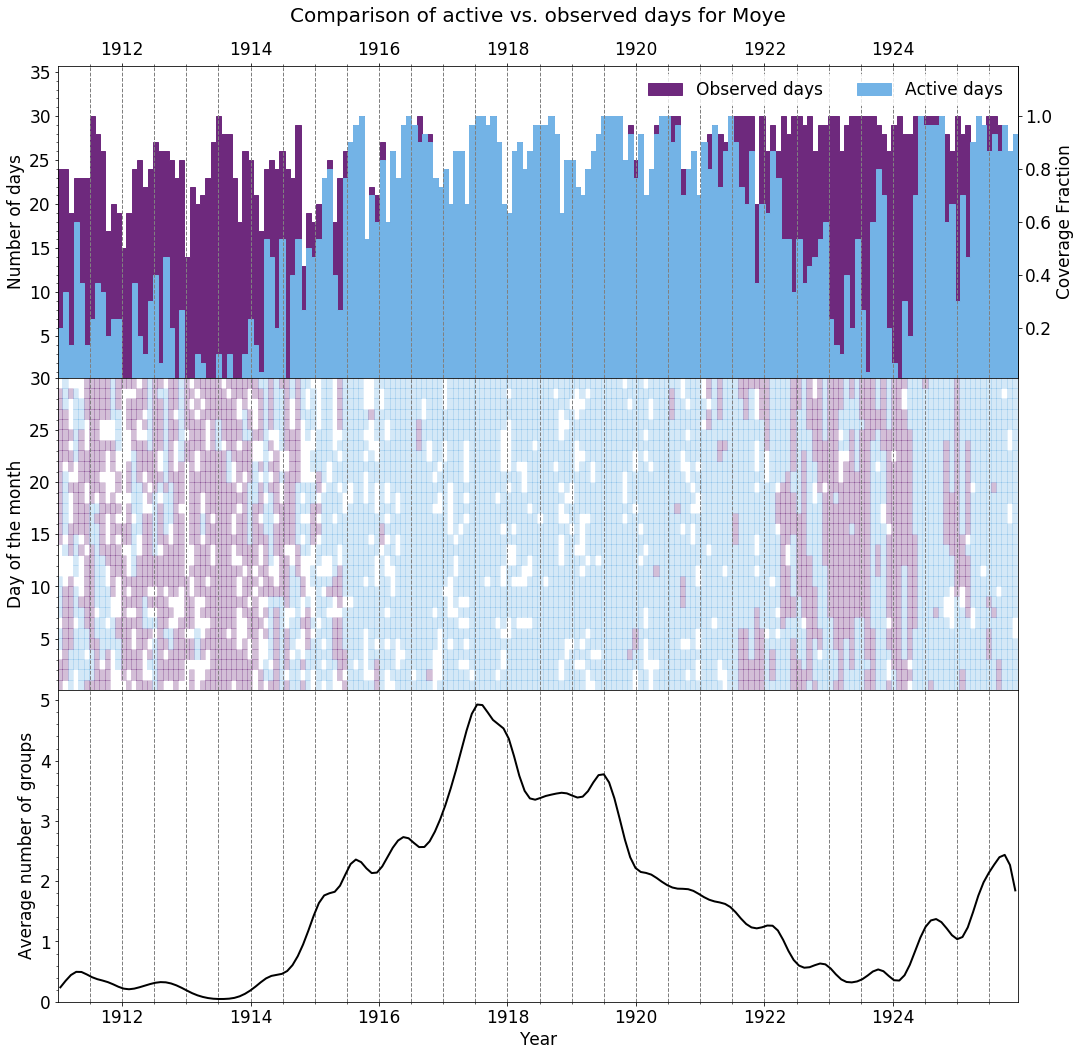

In [8]:
# Observer Plot
# Stack horizontal left ends to level the step-wise plot
pltxOb = np.stack((fyr1Ob,fyr1Ob)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltxOb = np.append(pltxOb,np.max(fyr2Ob))
pltxOb = np.append(pltxOb,np.max(fyr2Ob))

# Stack duplicate array to level the step-wise plot 
pltyOb = np.stack((obsOb,obsOb)).reshape((1,-1),order='F')
pltyGr = np.stack((grpOb,grpOb)).reshape((1,-1),order='F')
pltyAvOb = np.stack((AvGrpOb,AvGrpOb)).reshape((1,-1),order='F')
pltySd = np.stack((SdGrpOb,SdGrpOb)).reshape((1,-1),order='F')

# Append zeros to clamp area
pltyOb = np.insert(pltyOb,0,0)
pltyOb = np.append(pltyOb,0)

pltyGr = np.insert(pltyGr,0,0)
pltyGr = np.append(pltyGr,0)

pltyAvOb = np.insert(pltyAvOb,0,0)
pltyAvOb = np.append(pltyAvOb,0)

pltySd = np.insert(pltySd,0,0)
pltySd = np.append(pltySd,0)

plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units



## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

# Dummy axis for right scale
axd = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv])
axd.set_ylim(bottom = 0.01, top = 1.19)
axd.set_ylabel('Coverage Fraction')
axd.yaxis.set_label_position("right")
axd.yaxis.tick_right()


# Days with observations and active days
ax1 = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
# Add number of days with observations
ax1.fill(pltxOb, pltyOb, color = Clr[2])
ax1.fill(pltxOb, pltyGr, color = Clr[4])
# Add number of days with groups (not including zeros and days without observations)

# Axes properties
ax1.text(0.5, 1.14,'Comparison of active vs. observed days for ' + NamObs.capitalize(), horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
ax1.set_ylabel('Number of days')
ax1.legend(['Observed days','Active days'], loc = 'upper right', ncol = 2, frameon = True, edgecolor = 'none')
ax1.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.xaxis.tick_top()
ax1.minorticks_on()

# Active/observation/missing mesh
AcObMesh = np.isfinite(grpsOb).astype(int)+np.greater(grpsOb,0).astype(int)
xMesh = np.insert(fyr2Ob,0,fyr1Ob[0])
yMesh = np.arange(0,MoLngt+1)

#Colormap
colors = [(1, 1, 1), Clr[2], Clr[4]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax2 = fig.add_axes([ppadh, ppadv + pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
ax2.pcolormesh(xMesh, yMesh, np.transpose(AcObMesh), cmap = cmap, alpha = 0.3, linewidth = 2)
ax2.set_ylim(bottom = 0.1, top = MoLngt)

# Axes properties
ax2.set_ylabel('Day of the month')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax2.minorticks_on()

# Average group number 
ax3 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
#ax3.fill(pltxOb, pltyAvOb+pltySd, color = '0.8')
#ax3.fill(pltxOb, pltyAvOb-pltySd, color = 'w')
ax3.plot((fyr1Ob+fyr2Ob)/2, AvGrpOb, color = Clr[0], linewidth = 2)



# Axes properties
ax3.set_xlabel('Year')
ax3.set_ylabel('Average number of groups')
ax3.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax3.minorticks_on()
ax3.set_ylim(bottom = 0);

**FIGURE:** _Top:_ Number of active (non-zero; blue) and observed (purple) days during each month.

_Middle:_ Grid showing each day during the observed period as no-data (white), no groups (purple), and active (blue).  The vertical axis denotes the day of the month and the horizontal axis the edges of each month.

_Bottom:_ Average number of groups each month.

<a id='coverage'></a>
## Distributions of active day fractions and observed day fractions for given observer

The active day fraction method identifies the detection threshold of a given observer by identifying the closest cumulative distribution function observed by RGO after applying varying thresholds.  The concern is that focusing on the active day fraction only, without looking at the observed day fraction, may yield erroneous thresholds.  The distributions for the given observer look like this:

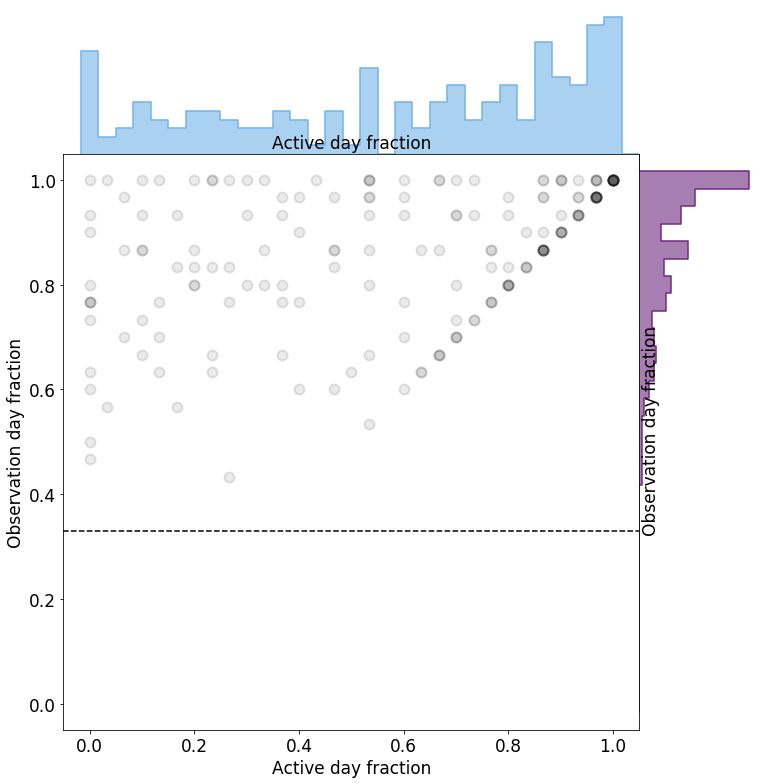

In [9]:
# Distribution Plots for Observer

# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Top Distribution
axd = fig.add_axes([ppadh, ppadv + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])
ADFObs, bins, patches = axd.hist(grpOb[obsOb/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color=Clr[4], alpha=.6, density = True);
(xAD, yAD) = histOutline(grpOb[obsOb/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
axd.plot(xAD, yAD, color=Clr[4])


# Axes properties
axd.set_xlim(left = -0.05, right = 1.05);
axd.set_axis_off()


# Right Distribution
ax2 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv, pxx/fszh*frc*(1-frc), pxy/fszv*frc])
ax2.hist(obsOb[obsOb/MoLngt>=minObD]/MoLngt, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color=Clr[2], alpha=.6, orientation = 'horizontal', density = True);
(xOD, yOD) = histOutline(obsOb[obsOb/MoLngt>=minObD]/MoLngt, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
ax2.plot(yOD, xOD, color=Clr[2])

# Axes properties
ax2.set_ylim(bottom = -0.05, top = 1.05);
ax2.set_axis_off()

# Scatter Plot
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
ax1.scatter(grpOb/MoLngt, obsOb/MoLngt, color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)
ax1.plot(np.array([-0.05,1.05]), np.array([1,1])*minObD, 'k--')

# Axes properties
ax1.set_ylabel('Observation day fraction')
ax1.text(1.02, 0.52,'Observation day fraction', horizontalalignment='center', transform = ax1.transAxes, 
         rotation = 'vertical', verticalalignment = 'center')
ax1.set_xlabel('Active day fraction')
ax1.text(0.5, 1.01,'Active day fraction', horizontalalignment='center', transform = ax1.transAxes)
ax1.set_xlim(left = -0.05, right = 1.05)
ax1.set_ylim(bottom = -0.05, top = 1.05);


**FIGURE:** Scatter plot connecting the active day and observed day fraction, as well as the marginal distributions for each of the quantities.   Colored areas indicate the distributions for the given observer and will be shown later for comparison with RGO.


# The Earth Mover's Distance (Wasserstein metric)

As part of our effort to make ADF more robust we introduce the Earth Mover's distance (EMD) to quantify how different are Observer's and RGO's distribution of ADFs.

[See description paper here](http://ai.stanford.edu/~rubner/papers/rubnerIjcv00.pdf)

The basic idea of the EMD is to depict distributions as piles of dirt and quantify the amount of "work" that an earth mover would need to do in order to transform one distribution into the other.   Here we use the pyemd package:

[https://github.com/wmayner/pyemd](https://github.com/wmayner/pyemd)


<a id='#parameters'></a>
# Calculating the Earth's Mover Distance using a sliding window an multiple observational thresholds

The idea is to optimize the fit between RGO's and the observer's ADF distributions simultaneously in time and threshold.  The cell below perfomrs this operation.

Additionally, if the observer has a coincident time with RGO, we calculate the EMD using exact matches.


In [29]:
from pyemd import emd

# Temporal Stride
dt = 365

# Number of thresholds 
thN = 20

# Threshold increments
thI = 5

# Calculation of distance matrix to be used in the Earth Movers Metric
x = np.arange(0,ADFObs.shape[0])
y = np.arange(0,ADFObs.shape[0])
xx, yy = np.meshgrid(x, y)
Dis = np.absolute(np.power(xx-yy,2))

EMD   = np.zeros((thN+1,int((RGO_Dat.shape[0]-ObsDat.shape[0])/dt)+1))
EMDt  = np.zeros((thN+1,int((RGO_Dat.shape[0]-ObsDat.shape[0])/dt)+1))
EMDth = np.zeros((thN+1,int((RGO_Dat.shape[0]-ObsDat.shape[0])/dt)+1))

for Idx1 in range(0,RGO_Dat.shape[0]-ObsDat.shape[0], dt):
    
    Idx2 = Idx1 + ObsDat.shape[0]    
    for i in range(0,thN+1):
    
        TgrpsRGO = np.nansum( np.greater(RGO_Dat.values[:,3:RGO_Dat.values.shape[1]-2],i*thI) ,axis = 1).astype(float)
        TgrpsRGO[np.isnan(RGO_Dat['AREA1'])] = np.nan

        #Reducing to period match
        TgrpsRGO = TgrpsRGO[Idx1:Idx2]
        
        # Selecting the maximum integer amount of "months" out of the original data
        TgrpsRGO = TgrpsRGO[0:np.int(TgrpsRGO.shape[0]/MoLngt)*MoLngt]
        # Reshaping
        TgrpsRGO = TgrpsRGO.reshape((-1,MoLngt))

        # Removing days using mask
        TgrpsRGO[np.isnan(grpsOb)] = np.nan
        
        # Doing the same for observer
        TgrpsOb = grpsOb.copy()
        TgrpsOb[np.isnan(TgrpsRGO)] = np.nan    

        # Number of days with groups
        CgrpRGOT = np.sum(np.greater(TgrpsRGO,0),axis=1)
        
        # Number of days with observations
        CobsRGO = np.sum(np.isfinite(TgrpsRGO),axis=1)
        
        # Number of days with observations
        TobsOb = np.sum(np.isfinite(TgrpsOb),axis=1)

        # Number of days with groups
        TgrpOb = np.sum(np.greater(TgrpsOb,0),axis=1)        

        # Calculating Earth Mover's Distance
        ADFRGO, bins = np.histogram(CgrpRGOT[CobsRGO/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
        ADFObs, bins = np.histogram(TgrpOb[TobsOb/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
       
        EMD[i,int(Idx1/dt)] = emd(ADFRGO.astype(np.float64),ADFObs.astype(np.float64),Dis.astype(np.float64))
        
        # Udating time and threshold vectors
        EMDt[i,int(Idx1/dt)] = Idx1
        EMDth[i,int(Idx1/dt)] = i*thI                 

# Creating matrix for sorting and find the best combinations of threshold and shift
OpMat = np.concatenate((EMDt.reshape((-1,1)),EMDth.reshape((-1,1)),EMD.reshape((-1,1))), axis = 1)

# Sort according to EMD to find the best matches
I = np.argsort(OpMat[:,2],axis = 0)
OpMat = np.squeeze(OpMat[I,:])


## Add the real interval if it exists

#Initialize varialbes to identify the optimum threshold for the period of overlap
tmpEMD = np.nan
tmpt   = np.nan
tmpth  = np.nan

if ( np.min(RGO_Dat['ORDINAL'])<=np.min(ObsDat['ORDINAL']) ) and ( np.max(RGO_Dat['ORDINAL'])>=np.max(ObsDat['ORDINAL']) ):
    
    # Find indices that coincide with the observational interval
    Idx1 = np.where(RGO_Dat['ORDINAL'].values.astype(int)==np.min(ObsDat['ORDINAL']))[0][0]
    Idx2 = np.where(RGO_Dat['ORDINAL'].values==np.max(ObsDat['ORDINAL']))[0][0]
    
    # Initialize tmpEMD with a very large value so that it can be overwriten when a smaller value is found
    tmpEMD = 1e16
    
    # Initialize variables to store the true time
    EMDTT   = np.zeros((thN+1))
    EMDthTT = np.zeros((thN+1))
    EMDtTT  = Idx1
    
    #Find EMD for the interval
    for i in range(0,thN+1):
    
        TgrpsRGO = np.nansum( np.greater(RGO_Dat.values[:,3:RGO_Dat.values.shape[1]-2],i*thI) ,axis = 1).astype(float)
        TgrpsRGO[np.isnan(RGO_Dat['AREA1'])] = np.nan

        #Reducing to period match
        TgrpsRGO = TgrpsRGO[Idx1:Idx2]
        
        # Selecting the maximum integer amount of "months" out of the original data
        TgrpsRGO = TgrpsRGO[0:np.int(TgrpsRGO.shape[0]/MoLngt)*MoLngt]
        # Reshaping
        TgrpsRGO = TgrpsRGO.reshape((-1,MoLngt))

        # Removing days using mask
        TgrpsRGO[np.isnan(grpsOb)] = np.nan
        
        # Doing the same for observer
        TgrpsOb = grpsOb.copy()
        TgrpsOb[np.isnan(TgrpsRGO)] = np.nan    

        # Number of days with groups
        CgrpRGOT = np.sum(np.greater(TgrpsRGO,0),axis=1)
        
        # Number of days with observations
        CobsRGO = np.sum(np.isfinite(TgrpsRGO),axis=1)
        
        # Number of days with observations
        TobsOb = np.sum(np.isfinite(TgrpsOb),axis=1)

        # Number of days with groups
        TgrpOb = np.sum(np.greater(TgrpsOb,0),axis=1)        

        # Calculating Earth Mover's Distance
        ADFRGO, bins = np.histogram(CgrpRGOT[CobsRGO/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
        ADFObs, bins = np.histogram(TgrpOb[TobsOb/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)

        tmp = emd(ADFRGO.astype(np.float64),ADFObs.astype(np.float64),Dis.astype(np.float64))
        
        # Storing for dis-plot
        EMDTT[i] = tmp
        
        # Udating time and threshold vectors
        EMDthTT[i] = i*thI         
        
        # Udating variables
        if tmp<tmpEMD:
            tmpEMD = tmp
            tmpt   = Idx1
            tmpth  = i*thI
            
OpMat = np.insert(OpMat,0,[tmpt,tmpth,tmpEMD],axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in greater


## Display the time/threshold EMD optimization matrix and best points

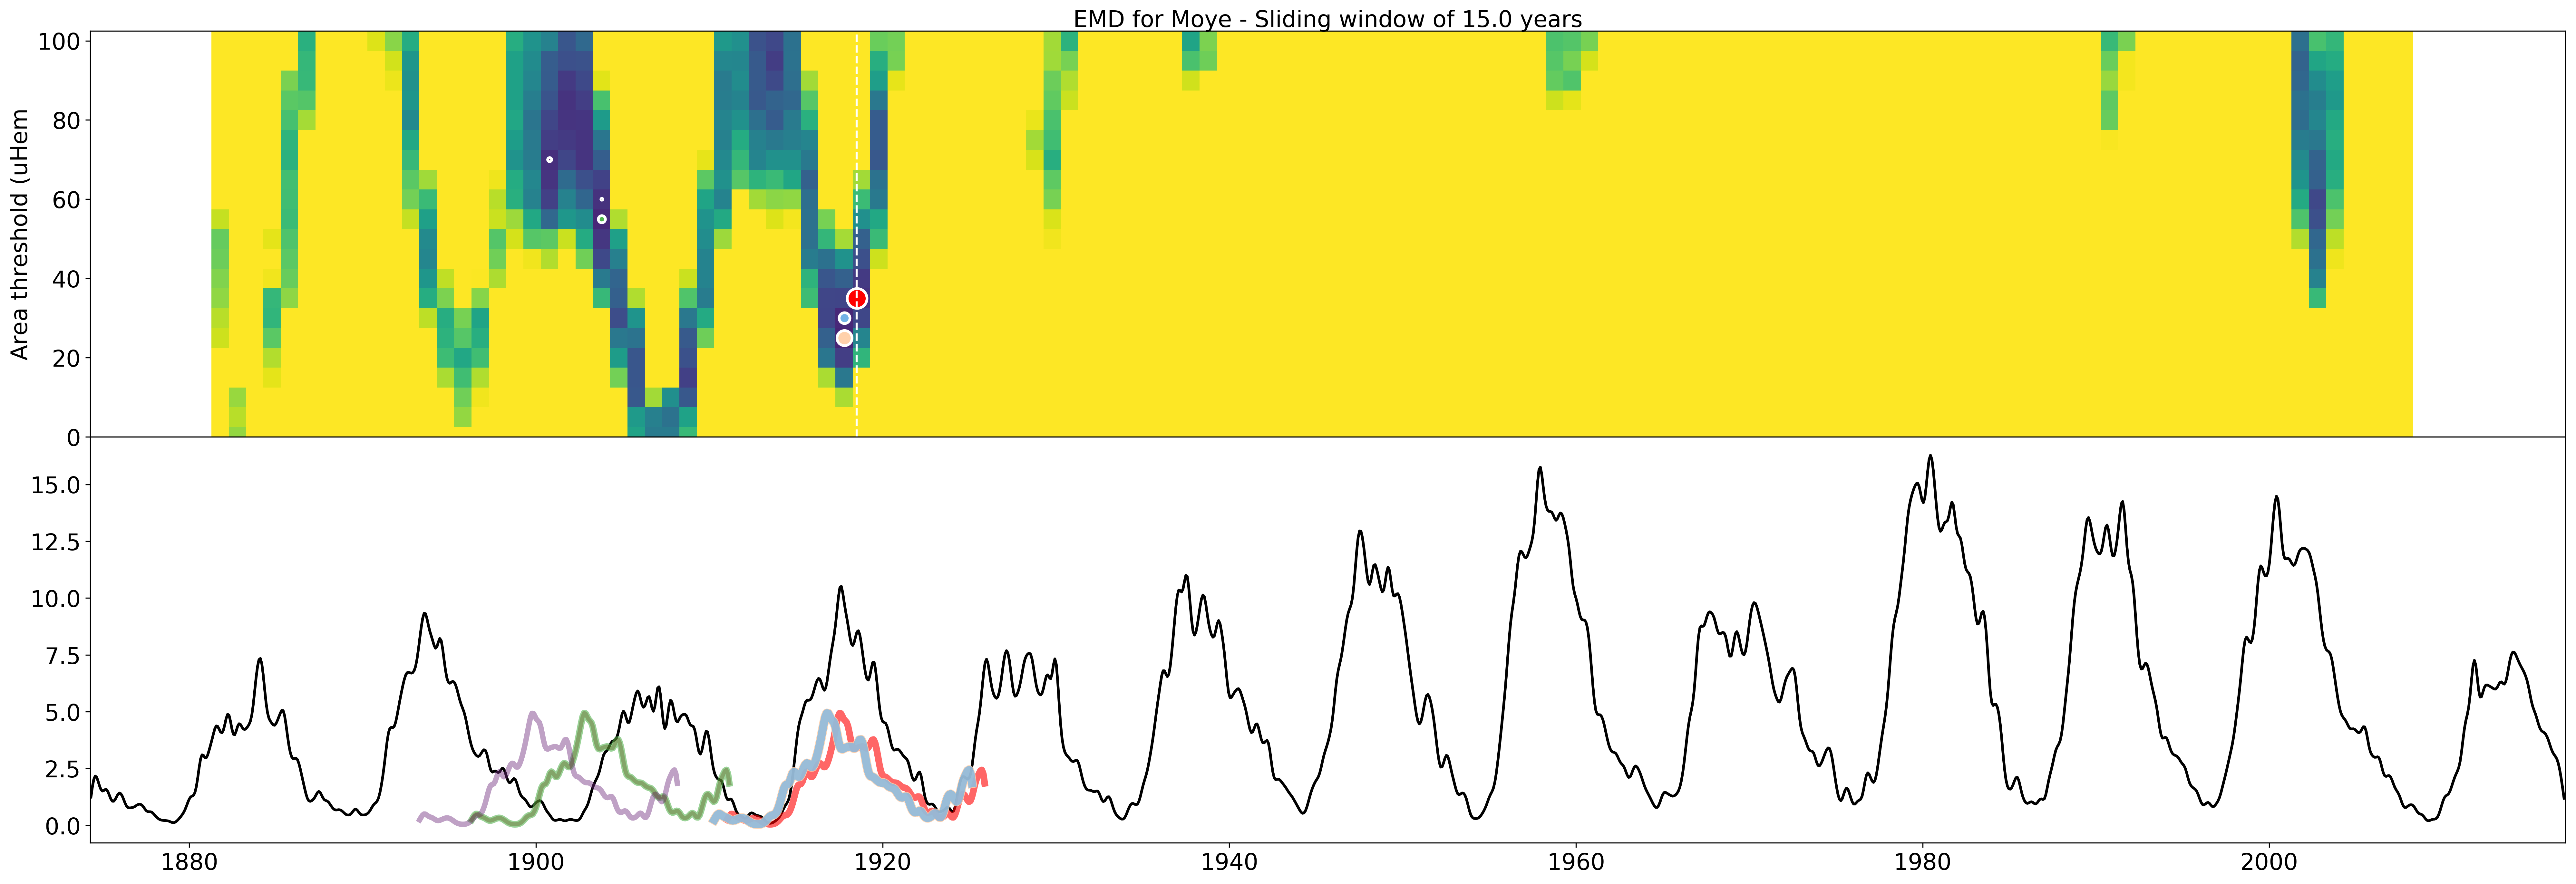

In [30]:
# Plot Optimization Matrix
# Finding delta in years to locat the center of the window
xDel = RGO_Dat.loc[0,'FRACYEAR'] + (np.max(ObsDat['FRACYEAR'])-np.min(ObsDat['FRACYEAR']))/2

# Determine plotting vectors
xMesh = EMDt[0,:]-dt/2
yMesh = EMDth[:,0]-thI/2
yMesh = np.append(yMesh,np.max(yMesh)+thI)




# RGO plot
# Stack horizontal left ends to level the step-wise plot
pltx = np.stack((fyr1RGO,fyr1RGO)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltx = np.append(pltx,np.max(fyr2RGO))
pltx = np.append(pltx,np.max(fyr2RGO))

# Stack duplicate array to level the step-wise plot 
pltyAv = np.stack((AvGrpRGO,AvGrpRGO)).reshape((1,-1),order='F')

# Append zeros to clamp area
pltyAv = np.insert(pltyAv,0,0)
pltyAv = np.append(pltyAv,0)


# Size definitions
dpi = 300
pxx = EMD.shape[1]*60*dt/365   # Horizontal size of each panel
pxy = EMD.shape[0]*60   # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 2      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# EMD Pcolor
plt.viridis()
ax1 = fig.add_axes([ppadh, ppadv + pxy/fszv , pxx/fszh, pxy/fszv])
mesh = ax1.pcolormesh(xMesh/365 + xDel, yMesh, EMD, alpha = 1, linewidth = 2, vmin = np.min(EMDt), vmax = 10*np.min(EMD))
# Center of true window
ax1.plot(np.array([1,1])*(np.min(ObsDat['FRACYEAR'])+np.max(ObsDat['FRACYEAR']))/2, np.array([0,np.max(yMesh)]),'w--')


# True Interval
ax1.scatter(OpMat[0,0]/365 + xDel, OpMat[0,1], c = 'r', edgecolors = 'w',linewidths = 2, s = np.power(6,3)+1)
# Best points
for i in range(1,6):
    ax1.scatter(OpMat[i,0]/365 + xDel, OpMat[i,1], c = Clr[6-i], edgecolors = 'w',linewidths = 2, s = np.power(6-i,3)+1)



    
# Axes properties
ax1.set_ylabel('Area threshold (uHem')
ax1.set_xlabel('Center of sliding window (Year)')
ax1.text(0.5, 1.01,'EMD for ' + NamObs.capitalize() + ' - Sliding window of ' + str(np.round_(np.max(ObsDat['FRACYEAR'])-np.min(ObsDat['FRACYEAR']),2)) + ' years'
         , horizontalalignment='center', transform = ax1.transAxes)
ax1.set_xlim(left = np.min(RGO_Dat['FRACYEAR']), right = np.max(RGO_Dat['FRACYEAR']))
ax1.set_ylim(bottom = 0, top = np.max(yMesh))

#Colorbar
#cbar = fig.colorbar(mesh)
#cbar.set_label('EMD saturated at 10xMin(EMD)')


# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax2.plot((fyr1RGO+fyr2RGO)/2, AvGrpRGO, color = Clr[0], linewidth = 2)

Idx1/365+RGO_Dat.loc[0,'FRACYEAR']

ax2.plot((fyr1Ob+fyr2Ob)/2 - np.min((fyr1Ob+fyr2Ob)/2) + RGO_Dat.loc[0,'FRACYEAR'] + OpMat[0,0]/365, AvGrpOb, color = 'r', linewidth = 5, alpha = 0.6)
for i in range(1,6):
    ax2.plot((fyr1Ob+fyr2Ob)/2 - np.min((fyr1Ob+fyr2Ob)/2) + RGO_Dat.loc[0,'FRACYEAR'] + OpMat[i,0]/365, AvGrpOb, color = Clr[6-i], linewidth = 8-i, alpha = 1-1.4*i/10)

# Axes properties
ax2.set_xlim(left = np.min(RGO_Dat['FRACYEAR']), right = np.max(RGO_Dat['FRACYEAR']));

**FIGURES:** _TOP:_ Optimization matrix in time (x) and threshold (y).  Color indicates EMD distance with dark blue being the smallest EMD and yellow 10 times the smallest EMD.  Circles show the 5 smallest EMD points. Their size indicates rank (biggest is the best) Colors are used to connect with the data plots below.    In the case where the observer has full overlap with RGO, the big red dot indicates the optimum match.

_BOTTOM:_ RGO era with overlapping plots of the observers interval shifted to match the optimum points found above.  A red curve (when available), indicates the real observatios


## Displaying best ADF distributions


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater


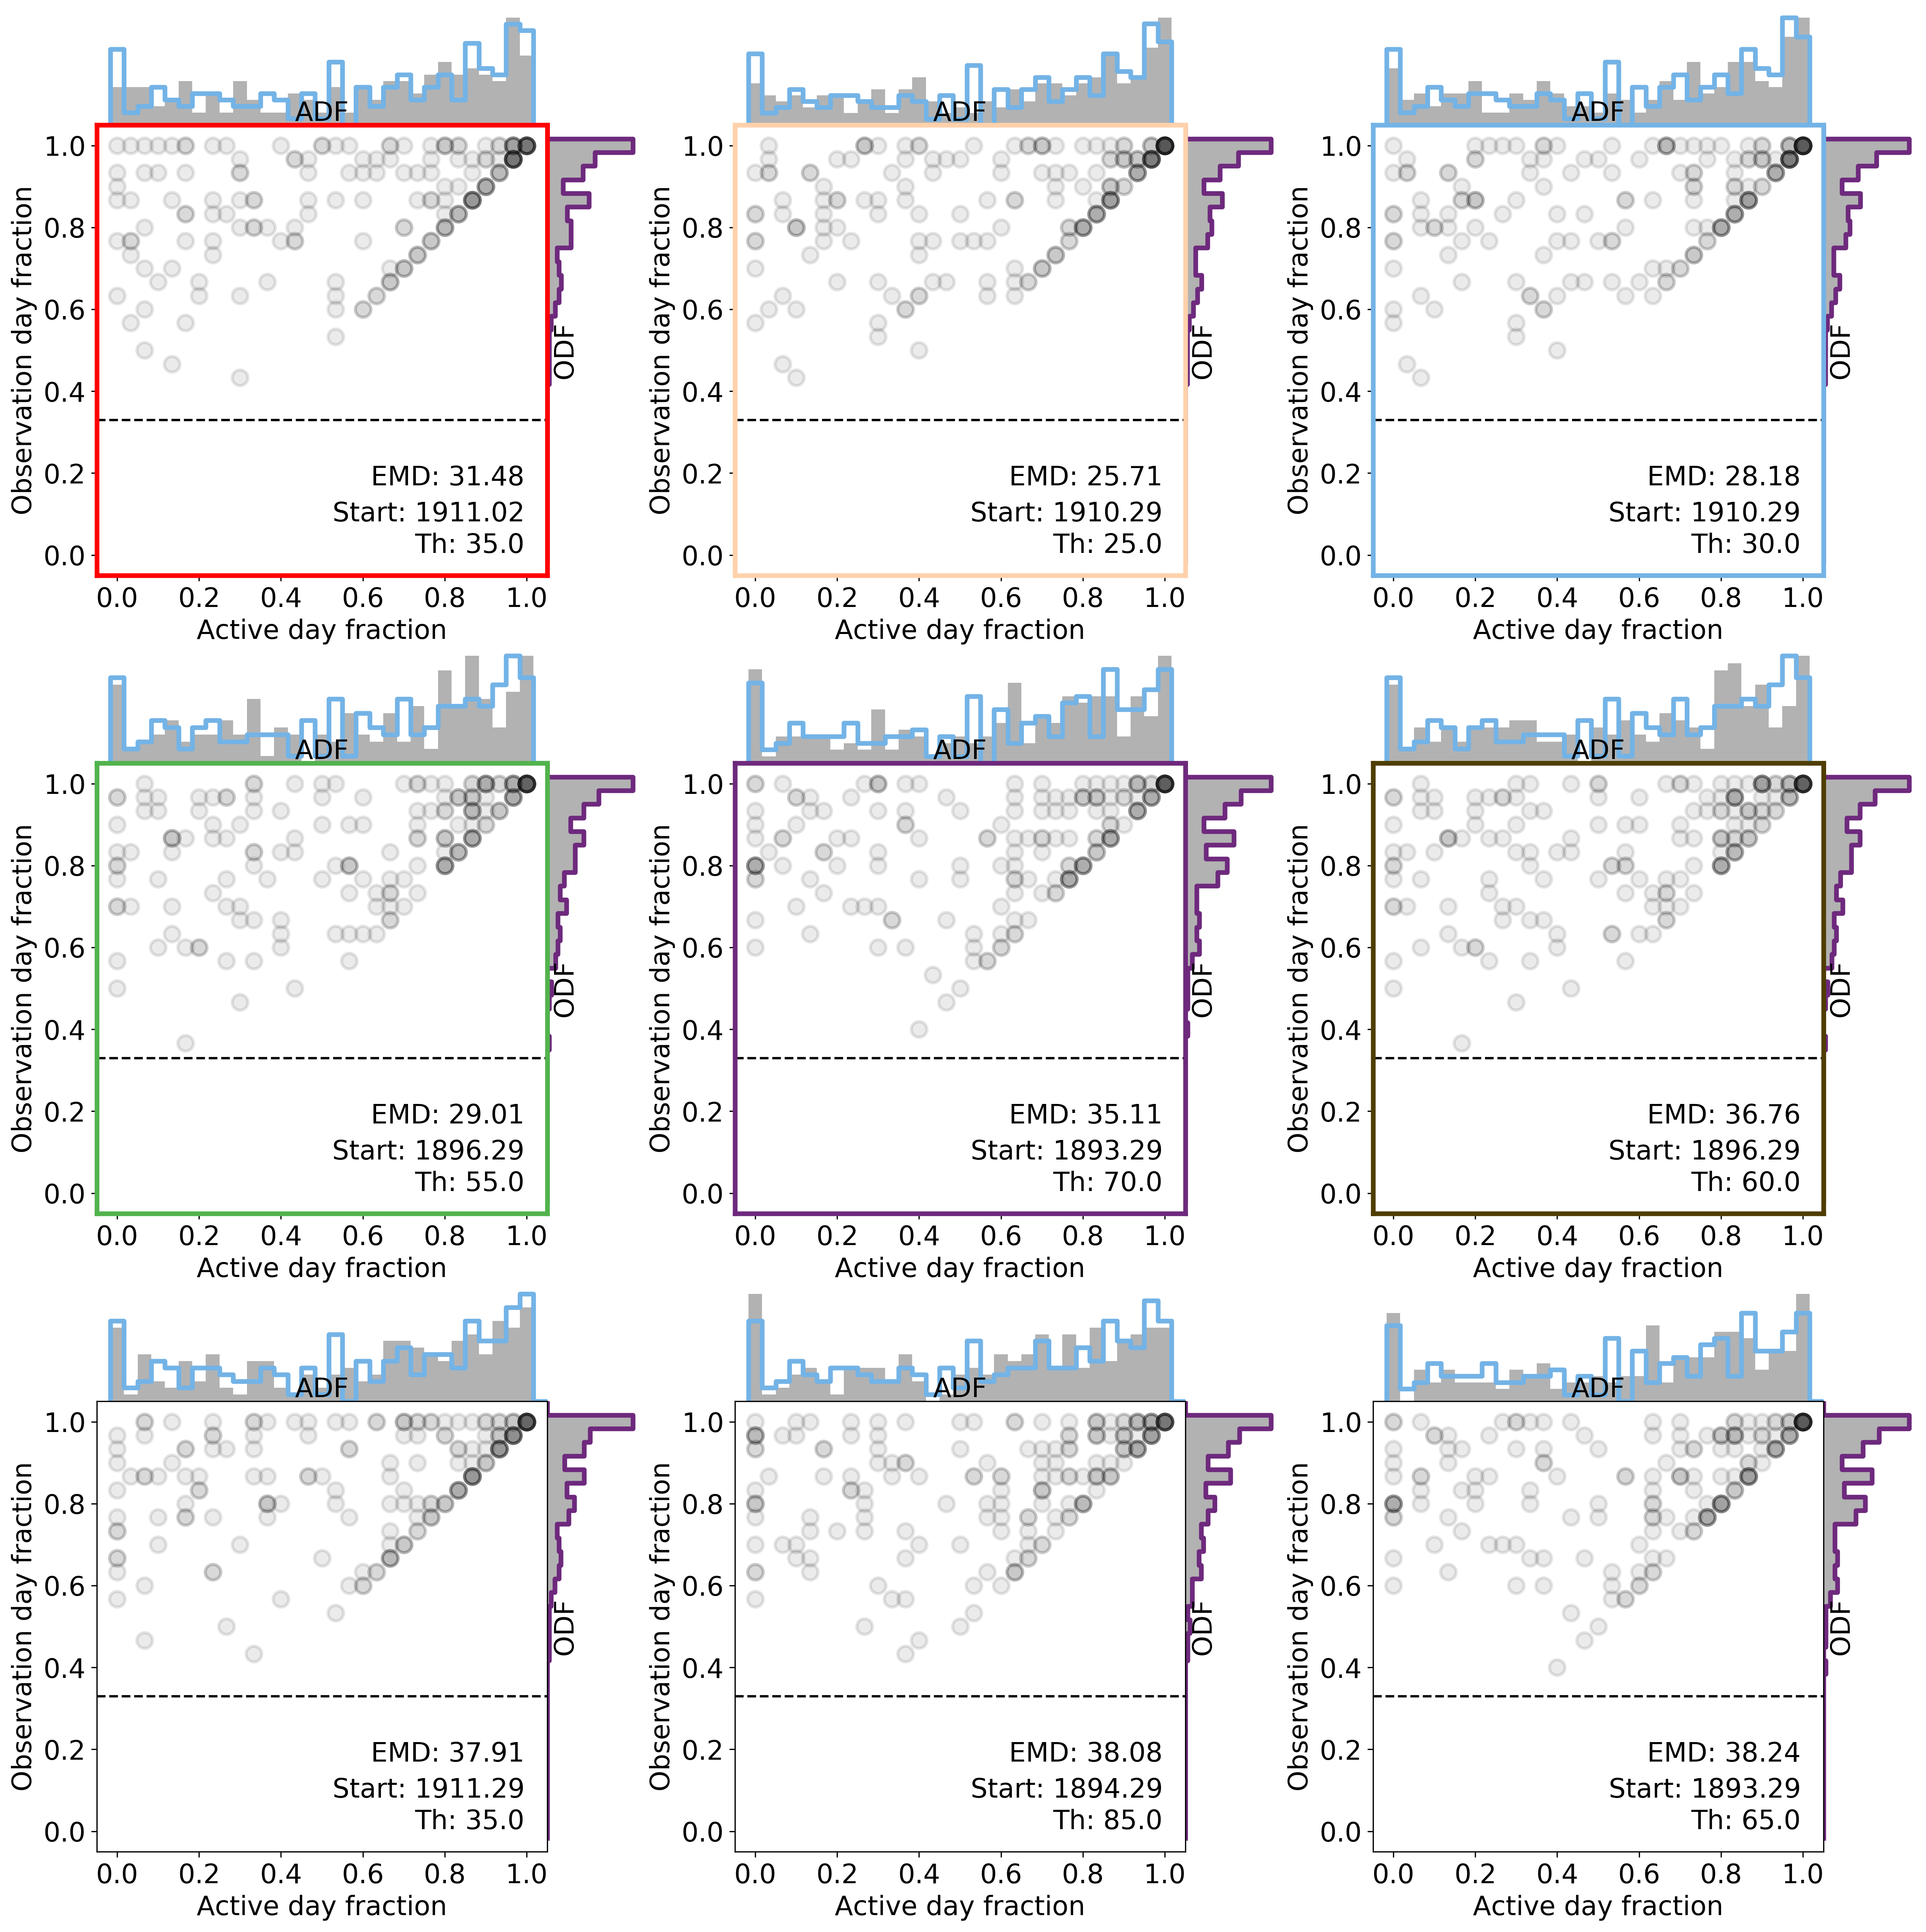

In [41]:
# Distribution Plots for RGO
# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 200 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


for i in range(0, 3):
    for j in range(0,3):
        n = (3*(2-j)+i)
        if np.isfinite(OpMat[n,0]):

            Idx1 = int(OpMat[n,0])
            Idx2 = Idx1 + ObsDat.shape[0]
            Th   = OpMat[n,1]

            TgrpsRGO = np.nansum( np.greater(RGO_Dat.values[:,3:RGO_Dat.values.shape[1]-2],Th) ,axis = 1).astype(float)
            TgrpsRGO[np.isnan(RGO_Dat['AREA1'])] = np.nan

            #Reducing to period match
            TgrpsRGO = TgrpsRGO[Idx1:Idx2]

            # Selecting the maximum integer amount of "months" out of the original data
            TgrpsRGO = TgrpsRGO[0:np.int(TgrpsRGO.shape[0]/MoLngt)*MoLngt]
            # Reshaping
            TgrpsRGO = TgrpsRGO.reshape((-1,MoLngt))

            # Removing days using mask
            TgrpsRGO[np.isnan(grpsOb)] = np.nan

            # Doing the same for observer
            TgrpsOb = grpsOb.copy()
            TgrpsOb[np.isnan(TgrpsRGO)] = np.nan    

            # Number of days with groups
            CgrpRGOT = np.sum(np.greater(TgrpsRGO,0),axis=1)

            # Number of days with observations
            CobsRGO = np.sum(np.isfinite(TgrpsRGO),axis=1)

            # Number of days with observations
            TobsOb = np.sum(np.isfinite(TgrpsOb),axis=1)

            # Number of days with groups
            TgrpOb = np.sum(np.greater(TgrpsOb,0),axis=1)        

            (xAD, yAD) = histOutline(TgrpOb[TobsOb/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)

            # Top Distribution
            ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) , ppadv + j*(pxy/fszv+ppadv2) + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])
            ax1.hist(CgrpRGOT[CobsRGO/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color='0.5', alpha=.6, density = True);
            ax1.plot(xAD, yAD, color=Clr[4], linewidth=3)

            # Axes properties
            ax1.set_xlim(left = -0.05, right = 1.05);
            ax1.set_axis_off()

            (xOD, yOD) = histOutline(TobsOb[TobsOb/MoLngt>=minObD]/MoLngt, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)

            # Right Distribution
            ax2 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) + pxx/fszh*frc, ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc*(1-frc), pxy/fszv*frc])
            ax2.hist(CobsRGO[CobsRGO/MoLngt>=minObD]/MoLngt, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color='0.5', alpha=.6, orientation = 'horizontal', density = True);
            ax2.plot(yOD, xOD, color=Clr[2], linewidth=3)

            # Axes properties
            ax2.set_ylim(bottom = -0.05, top = 1.05);
            ax2.set_axis_off()

            # Scatter Plot
            ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2), ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
            ax1.scatter(CgrpRGOT/MoLngt, CobsRGO/MoLngt, color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)
            ax1.plot(np.array([-0.05,1.05]), np.array([1,1])*minObD, 'k--')

            # Axes properties
            ax1.set_ylabel('Observation day fraction')
            ax1.text(1.04, 0.5,'ODF', horizontalalignment='center', transform = ax1.transAxes, 
                     rotation = 'vertical', verticalalignment = 'center')
            ax1.set_xlabel('Active day fraction')
            ax1.text(0.5, 1.01,'ADF', horizontalalignment='center', transform = ax1.transAxes)
            ax1.text(0.95, 0.2,  'EMD: ' + str(np.round_(OpMat[n,2], decimals = 2)), horizontalalignment='right', transform = ax1.transAxes)
            ax1.text(0.95, 0.12,  'Start: ' + str(np.round_(Idx1/365 + RGO_Dat.loc[0,'FRACYEAR'], decimals = 2)), horizontalalignment='right', transform = ax1.transAxes)
            ax1.text(0.95, 0.05,  'Th: ' + str(Th), horizontalalignment='right', transform = ax1.transAxes)
            ax1.set_xlim(left = -0.05, right = 1.05)
            ax1.set_ylim(bottom = -0.05, top = 1.05);

            if n==0:
                ax1.spines['bottom'].set_color('r')
                ax1.spines['bottom'].set_linewidth(3) 
                ax1.spines['top'].set_color('r') 
                ax1.spines['top'].set_linewidth(3)  
                ax1.spines['right'].set_color('r')
                ax1.spines['right'].set_linewidth(3) 
                ax1.spines['left'].set_color('r')
                ax1.spines['left'].set_linewidth(3) 

            elif (n<=5):
                ax1.spines['bottom'].set_color(Clr[6-n])
                ax1.spines['bottom'].set_linewidth(3) 
                ax1.spines['top'].set_color(Clr[6-n]) 
                ax1.spines['top'].set_linewidth(3) 
                ax1.spines['right'].set_color(Clr[6-n])
                ax1.spines['right'].set_linewidth(3) 
                ax1.spines['left'].set_color(Clr[6-n])
                ax1.spines['left'].set_linewidth(3) 
        


**FIGURE:** Each panel shows the scatter plot connecting the active day and observed day fraction, as well as the marginal distributions for each of the quantities. Gray shaded areas correspond to the distributions arising from RGO. Colored lines indicate the distributions for the given observer. Each panel denotes the time shift and thresholds used to obtain the distributions, as well as the Earth Mover's distance (EMD).  

The panels are outlined with colors connecting them with specific points/curves in the previous figure.  **The top left figure (when available) indicates the distributions for the true overlap between the observer and RGO.**

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater


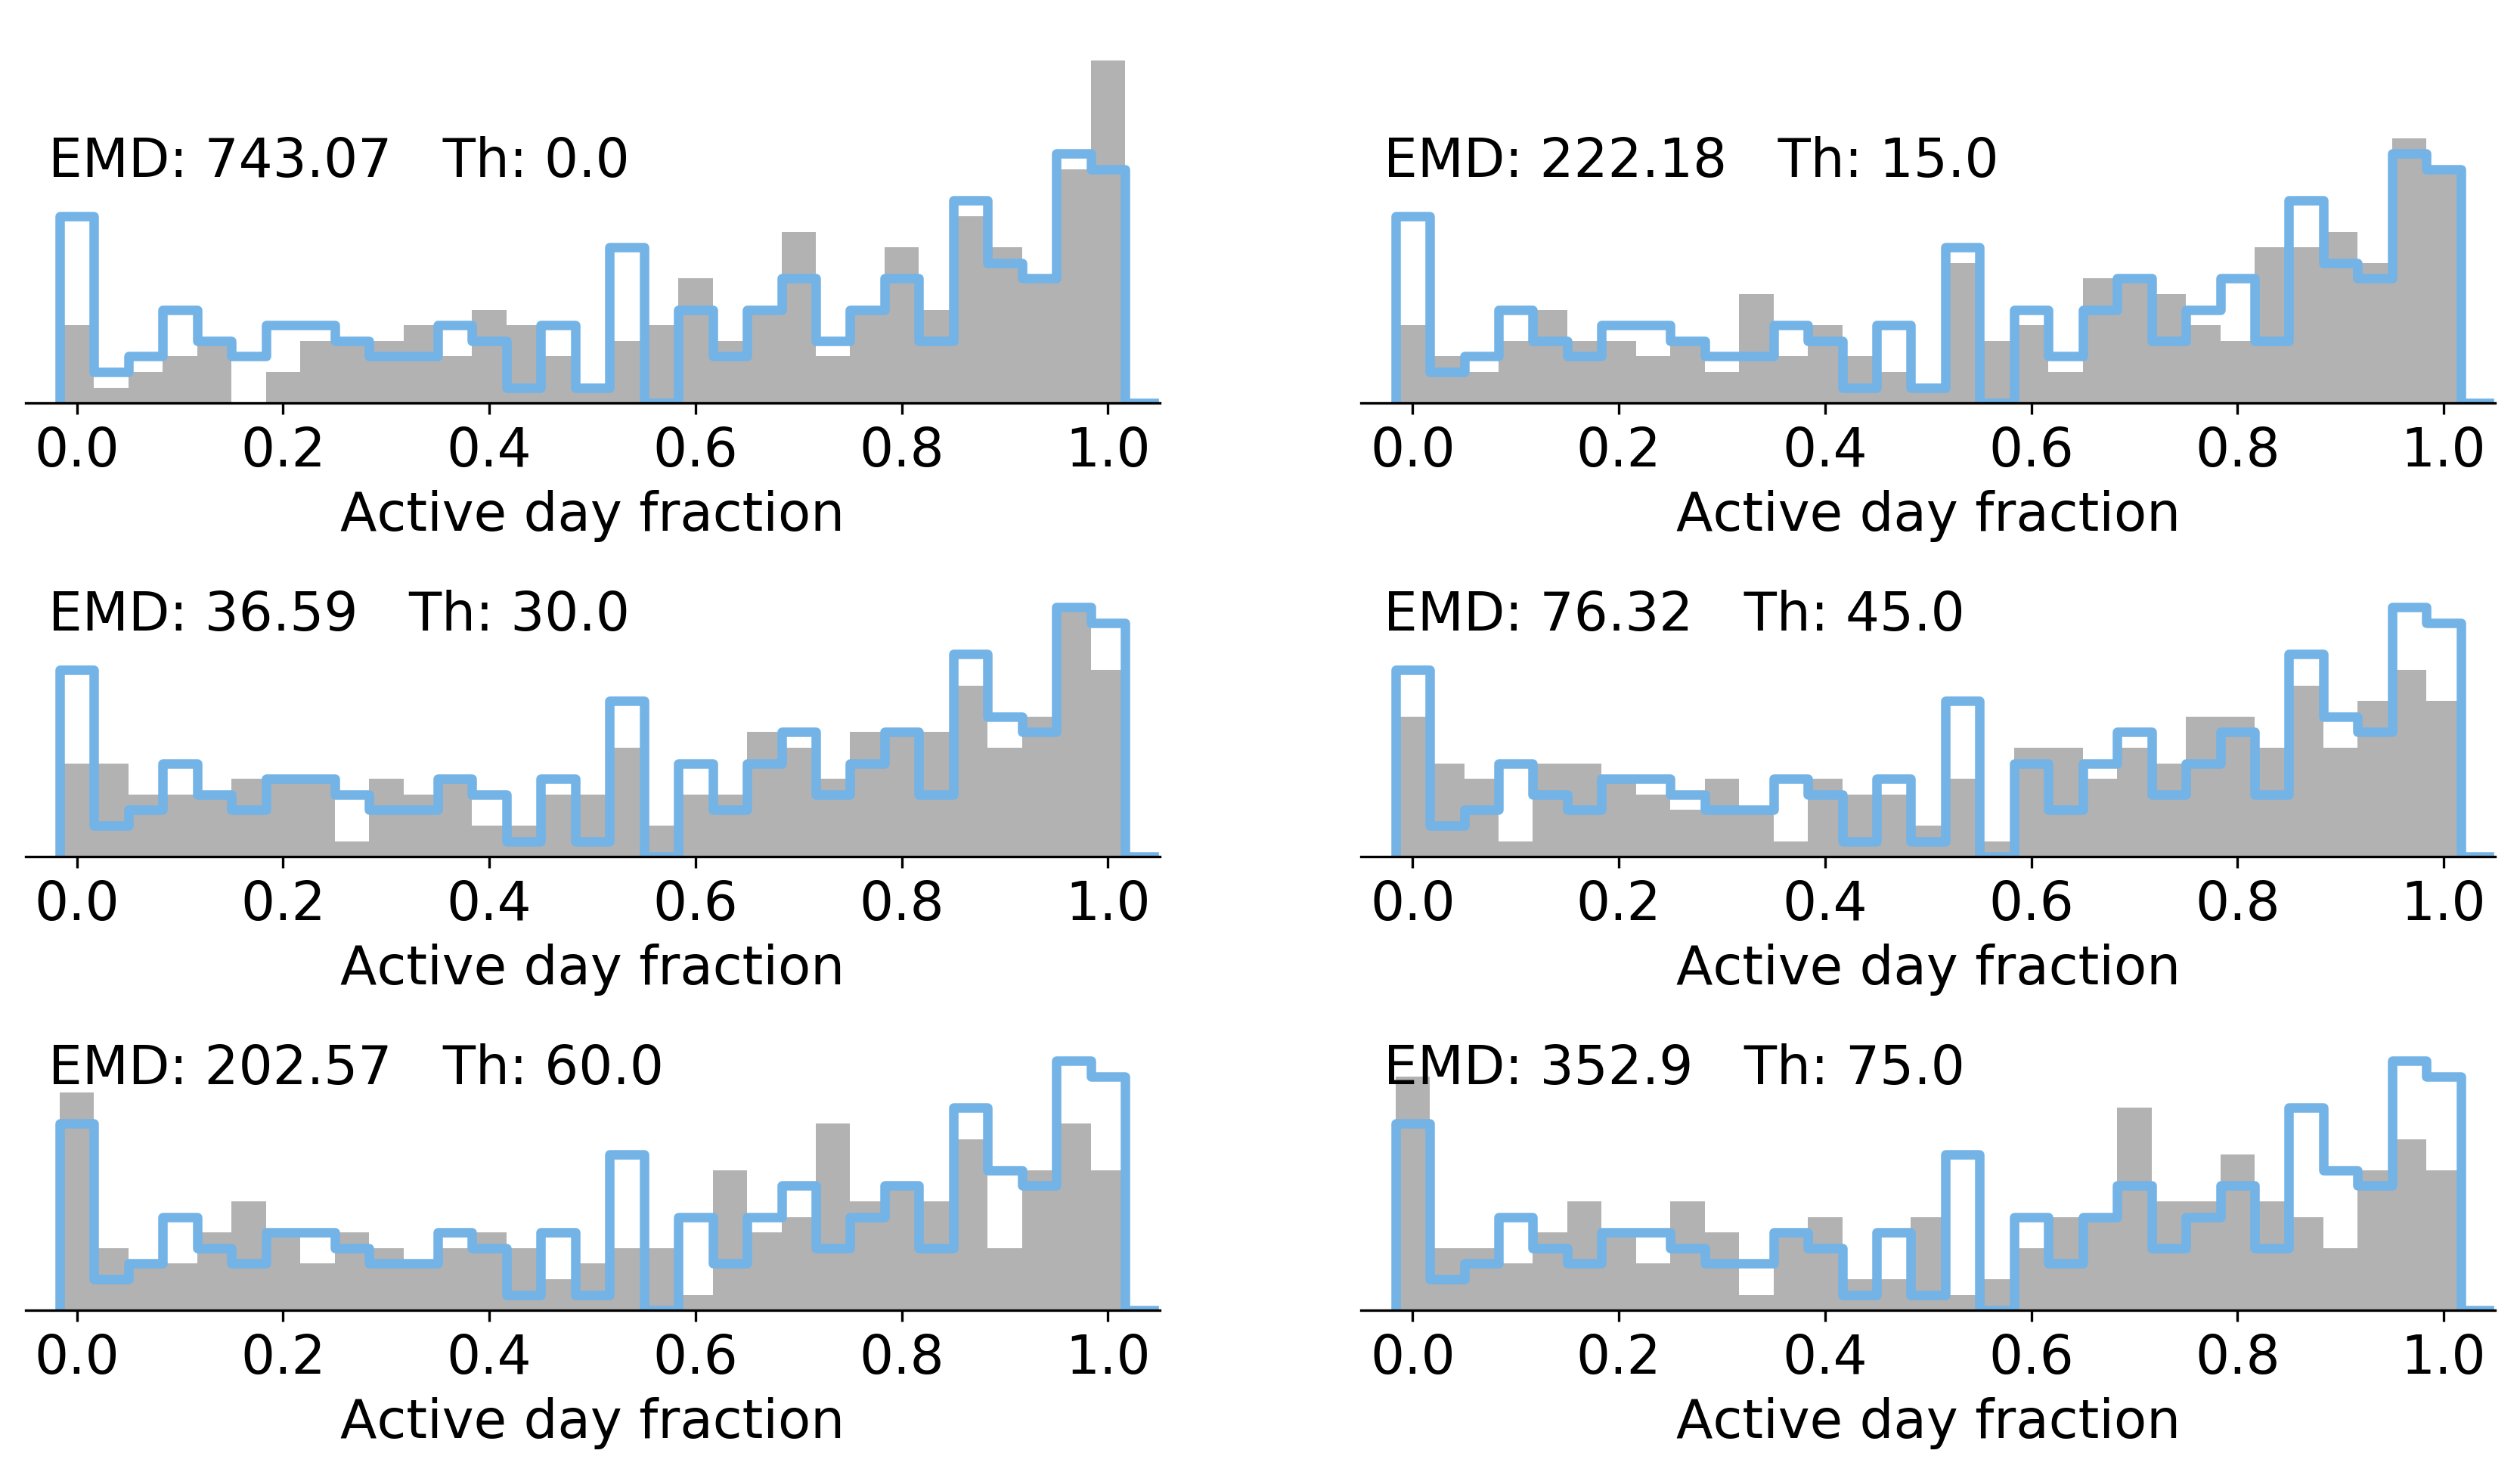

In [69]:
if ( np.min(RGO_Dat['ORDINAL'])<=np.min(ObsDat['ORDINAL']) ) and ( np.max(RGO_Dat['ORDINAL'])>=np.max(ObsDat['ORDINAL']) ):

    # Distribution Plots for RGO
    # Size definitions
    dpi = 300
    pxx = 1500   # Horizontal size of each panel
    pxy = 500    # Vertical size of each panel
    frc = 1    # Fraction of the panel devoted to histograms

    nph = 3      # Number of horizontal panels
    npv = 3      # Number of vertical panels

    # Padding
    padv  = 50 #Vertical padding in pixels
    padv2 = 100  #Vertical padding in pixels between panels
    padh  = 50 #Horizontal padding in pixels at the edge of the figure
    padh2 = 100 #Horizontal padding in pixels between panels

    # Figure sizes in pixels
    fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
    fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

    # Conversion to relative unites
    ppadv  = padv/fszv     #Vertical padding in relative units
    ppadv2 = padv2/fszv    #Vertical padding in relative units
    ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
    ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


    ## Start Figure
    fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


    Idx1 = EMDtTT
    Idx2 = Idx1 + ObsDat.shape[0]
    
    for i in range(0, 2):
        for j in range(0,3):
            n = 3*(2*(2-j)+i)

            Th   = EMDthTT[n]

            TgrpsRGO = np.nansum( np.greater(RGO_Dat.values[:,3:RGO_Dat.values.shape[1]-2],Th) ,axis = 1).astype(float)
            TgrpsRGO[np.isnan(RGO_Dat['AREA1'])] = np.nan

            #Reducing to period match
            TgrpsRGO = TgrpsRGO[Idx1:Idx2]

            # Selecting the maximum integer amount of "months" out of the original data
            TgrpsRGO = TgrpsRGO[0:np.int(TgrpsRGO.shape[0]/MoLngt)*MoLngt]
            # Reshaping
            TgrpsRGO = TgrpsRGO.reshape((-1,MoLngt))

            # Removing days using mask
            TgrpsRGO[np.isnan(grpsOb)] = np.nan

            # Doing the same for observer
            TgrpsOb = grpsOb.copy()
            TgrpsOb[np.isnan(TgrpsRGO)] = np.nan    

            # Number of days with groups
            CgrpRGOT = np.sum(np.greater(TgrpsRGO,0),axis=1)

            # Number of days with observations
            CobsRGO = np.sum(np.isfinite(TgrpsRGO),axis=1)

            # Number of days with observations
            TobsOb = np.sum(np.isfinite(TgrpsOb),axis=1)

            # Number of days with groups
            TgrpOb = np.sum(np.greater(TgrpsOb,0),axis=1)        

            (xAD, yAD) = histOutline(TgrpOb[TobsOb/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)

            # Scatter Plot
            ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2), ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
            ax1.hist(CgrpRGOT[CobsRGO/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color='0.5', alpha=.6, density = True);
            ax1.plot(xAD, yAD, color=Clr[4], linewidth=3)

            # Axes properties
            ax1.set_xlim(left = -0.05, right = 1.05);

            # Axes properties
            ax1.set_xlabel('Active day fraction')
            ax1.text(0.02, 0.6,  'EMD: ' + str(np.round_(EMDTT[n], decimals = 2)) + '   Th: ' + str(Th), horizontalalignment='left', transform = ax1.transAxes)
            ax1.set_xlim(left = -0.05, right = 1.05)
            ax1.set_ylim(bottom = 0, top = 4);
            ax1.set_yticklabels([])
            ax1.set_yticks([])
            
            ax1.spines['top'].set_color('w')
            ax1.spines['right'].set_color('w')
            ax1.spines['left'].set_color('w')
   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater


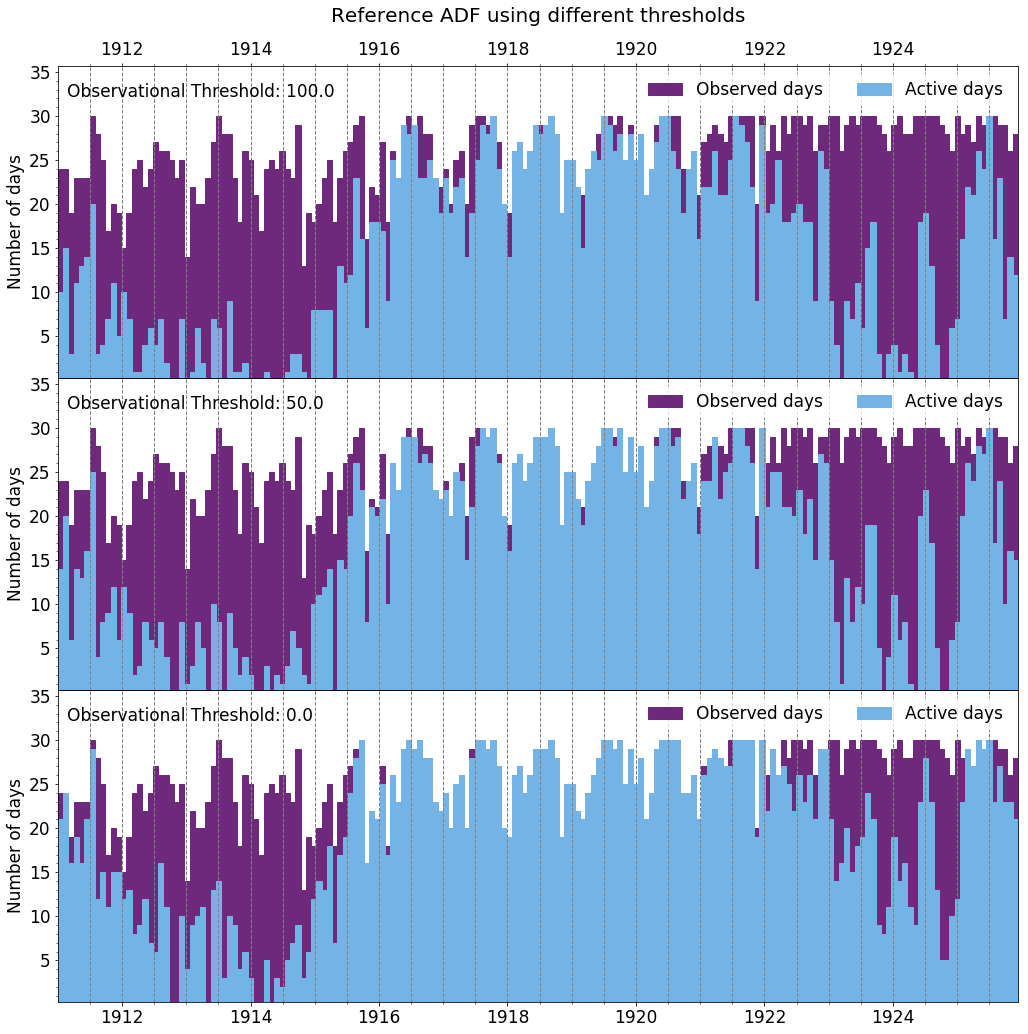

In [59]:
if ( np.min(RGO_Dat['ORDINAL'])<=np.min(ObsDat['ORDINAL']) ) and ( np.max(RGO_Dat['ORDINAL'])>=np.max(ObsDat['ORDINAL']) ):

    plt.rc('font', **font)

    # Size definitions
    dpi = 300
    pxx = 4000   # Horizontal size of each panel
    pxy = 1300    # Vertical size of each panel

    nph = 1      # Number of horizontal panels
    npv = 3      # Number of vertical panels

    # Padding
    padv  = 50 #Vertical padding in pixels
    padv2 = 0  #Vertical padding in pixels between panels
    padh  = 50 #Horizontal padding in pixels at the edge of the figure
    padh2 = 0 #Horizontal padding in pixels between panels

    # Figure sizes in pixels
    fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
    fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

    # Conversion to relative unites
    ppadv  = padv/fszv     #Vertical padding in relative units
    ppadv2 = padv2/fszv    #Vertical padding in relative units
    ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
    ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units

    pltxOb = np.stack((fyr1Ob,fyr1Ob)).reshape((1,-1),order='F')

    # Append max fracyear to clapm area
    pltxOb = np.append(pltxOb,np.max(fyr2Ob))
    pltxOb = np.append(pltxOb,np.max(fyr2Ob))


    ## Start Figure
    fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

    for i in range(0, npv):
        
        Th   = EMDthTT[10*i]

        TgrpsRGO = np.nansum( np.greater(RGO_Dat.values[:,3:RGO_Dat.values.shape[1]-2],Th) ,axis = 1).astype(float)
        TgrpsRGO[np.isnan(RGO_Dat['AREA1'])] = np.nan

        #Reducing to period match
        TgrpsRGO = TgrpsRGO[Idx1:Idx2]

        # Selecting the maximum integer amount of "months" out of the original data
        TgrpsRGO = TgrpsRGO[0:np.int(TgrpsRGO.shape[0]/MoLngt)*MoLngt]
        # Reshaping
        TgrpsRGO = TgrpsRGO.reshape((-1,MoLngt))

        # Removing days using mask
        TgrpsRGO[np.isnan(grpsOb)] = np.nan

        # Doing the same for observer
        TgrpsOb = grpsOb.copy()
        TgrpsOb[np.isnan(TgrpsRGO)] = np.nan    

        # Number of days with groups
        CgrpRGOT = np.sum(np.greater(TgrpsRGO,0),axis=1)

        # Number of days with observations
        CobsRGO = np.sum(np.isfinite(TgrpsRGO),axis=1)

        # Active/observation/missing mesh
        AcObMesh = np.isfinite(TgrpsRGO).astype(int)+np.greater(TgrpsRGO,0).astype(int)
        xMesh = np.insert(fyr2Ob,0,fyr1Ob[0])
        yMesh = np.arange(0,MoLngt+1)

        #Colormap
        colors = [(1, 1, 1), Clr[2], Clr[4]]
        cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

#         ax2 = fig.add_axes([ppadh, ppadv + i*pxy/fszv, pxx/fszh, pxy/fszv])
#         ax2.pcolormesh(xMesh, yMesh, np.transpose(AcObMesh), cmap = cmap, alpha = 0.3, linewidth = 2)
#         ax2.set_ylim(bottom = 0.1, top = MoLngt)

#         # Axes properties
#         ax2.set_ylabel('Day of the month')
#         ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
#         ax2.minorticks_on()
        
        


        # Stack duplicate array to level the step-wise plot 
        pltyOb = np.stack((CobsRGO,CobsRGO)).reshape((1,-1),order='F')
        pltyGr = np.stack((CgrpRGOT,CgrpRGOT)).reshape((1,-1),order='F')

        # Append zeros to clamp area
        pltyOb = np.insert(pltyOb,0,0)
        pltyOb = np.append(pltyOb,0)

        pltyGr = np.insert(pltyGr,0,0)
        pltyGr = np.append(pltyGr,0)
        
        ax1 = fig.add_axes([ppadh, ppadv + i*pxy/fszv, pxx/fszh, pxy/fszv])
        # Add number of days with observations
        ax1.fill(pltxOb, pltyOb, color = Clr[2])
        ax1.fill(pltxOb, pltyGr, color = Clr[4])
        # Add number of days with groups (not including zeros and days without observations)

        # Axes properties
        ax1.text(0.5, 1.14,'Reference ADF using different thresholds', horizontalalignment='center',
                 fontsize=20,
                 transform = ax1.transAxes)
        ax1.set_ylabel('Number of days')
        ax1.legend(['Observed days','Active days'], loc = 'upper right', ncol = 2, frameon = True, edgecolor = 'none')
        ax1.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
        ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
        ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
        if i!=0:
            ax1.xaxis.tick_top()
        ax1.minorticks_on()
        ax1.text(0.01, 0.9,'Observational Threshold: ' + str(Th), horizontalalignment='left', transform = ax1.transAxes)
        

In [44]:
EMDthTT.shape

(21,)